In [1]:
import os

# Désactiver le GPU en définissant CUDA_VISIBLE_DEVICES à un vide#
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [33]:
import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer

import RktnChallenge.preprocessing.tokenizeString
importlib.reload(RktnChallenge.preprocessing.tokenizeString)
from RktnChallenge.preprocessing.tokenizeString import tokenizeString

import RktnChallenge.preprocessing.filterStopWords
importlib.reload(RktnChallenge.preprocessing.filterStopWords)
from RktnChallenge.preprocessing.filterStopWords import filterStopWords


import RktnChallenge.preprocessing.mergeFeatures
importlib.reload(RktnChallenge.preprocessing.mergeFeatures)
from RktnChallenge.preprocessing.mergeFeatures import mergeFeatures

import RktnChallenge.preprocessing.mostOccur
importlib.reload(RktnChallenge.preprocessing.mostOccur)
from RktnChallenge.preprocessing.mostOccur import mostOccur

import RktnChallenge.preprocessing.Dropper
importlib.reload(RktnChallenge.preprocessing.Dropper)
from RktnChallenge.preprocessing.Dropper import Dropper

import RktnChallenge.preprocessing.TokenListToString
importlib.reload(RktnChallenge.preprocessing.TokenListToString)
from RktnChallenge.preprocessing.TokenListToString import TokenListToString

In [34]:
RktnModel_desi = ModelTrainer("data_tr_test.csv")
RktnModel_desc = ModelTrainer("data_tr_test.csv")
RktnModel_desi.data = RktnModel_desi.data[RktnModel_desi.data.description.isna()]
RktnModel_desc.data = RktnModel_desc.data[RktnModel_desc.data.description.notna()]

desc_max_seq_length =1202
desi_max_seq_length=47

Traitement Desc

In [36]:
addendum = ['a','à','<p>','<b>','<div>','<em>','<br>']

#on tokenise et retire les stopwords designation

desi_tokenize= tokenizeString("designation_tkn","designation")
desi_stopwords = filterStopWords("designation_tkn", "designation_tkn"
                                 ,lang=["english","french"],addendum=addendum)


#on tokenise et retire les stopwords description
desc_tokenize= tokenizeString("description_tkn","description")
desc_stopwords = filterStopWords("description_tkn", "description_tkn"
                                 ,lang=["english","french"],addendum=addendum)



merge_desi_desc = mergeFeatures("merged","designation_tkn","description_tkn")
desc_mostOccur= mostOccur("merged_desi_desc","merged",1000,1000)



toDrop = ["designation_tkn","description_tkn","merged"]
cleanDropper = Dropper(column_to_drop = toDrop)
toString = TokenListToString("merged_desi_desc","merged_desi_desc")

RktnModel_desc.initPreprocess()
RktnModel_desc.addPreprocessStep("tokenize designation",desi_tokenize) # transformation en token
RktnModel_desc.addPreprocessStep("filter designation",desi_stopwords)  # filtrage des stopwords
RktnModel_desc.addPreprocessStep("tokenize description",desc_tokenize) # transformation en token
RktnModel_desc.addPreprocessStep("filter description",desc_stopwords)  # filtrage des stopwords
RktnModel_desc.addPreprocessStep("merge designation and desc",merge_desi_desc) # merge desi&desc
RktnModel_desc.addPreprocessStep("desc reduce",desc_mostOccur)         # reduction taille desc
RktnModel_desc.addPreprocessStep("tostring",toString) # merge desi&desc

#RktnModel.addPreprocessStep("cleaning",cleanDropper) # on clean les colonnes crées
RktnModel_desc.preprocess()

_X = RktnModel_desc.data["merged_desi_desc"]

#on charge le tokenizer
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('desc_tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

X_desc_ = tokenizer.texts_to_sequences(_X)     
X_desc = pad_sequences(X_desc_, maxlen=desc_max_seq_length, padding='post', truncating='post')
import joblib
label_encoder = joblib.load('desc_encoder.pkl')
y_desc = label_encoder.transform(RktnModel_desc.data.prdtypecode)

model_desc = tf.keras.models.load_model("model_description.h5")

y_pred_desc = model_desc.predict(X_desc)
y_pred_desc = y_pred_desc.argmax(axis=-1)


[nltk_data] Downloading package stopwords to /home/pec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


344/344 [==============================] - 4s 10ms/step


In [37]:
addendum = ['a','à','<p>','<b>','<div>','<em>','<br>']

#on tokenise et retire les stopwords designation

desi_tokenize= tokenizeString("designation_tkn","designation")
desi_stopwords = filterStopWords("merged_desi_desc", "designation_tkn"
                                 ,lang=["english","french"],addendum=addendum)



RktnModel_desi.initPreprocess()
RktnModel_desi.addPreprocessStep("tokenize designation",desi_tokenize) # transformation en token
RktnModel_desi.addPreprocessStep("filter designation",desi_stopwords)  # filtrage des stopwords



#RktnModel.addPreprocessStep("cleaning",cleanDropper) # on clean les colonnes crées
RktnModel_desi.data = RktnModel_desi.preprocess()

_X = RktnModel_desi.data["merged_desi_desc"]

#on charge le tokenizer
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open('desi_tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

X_desi_ = tokenizer.texts_to_sequences(_X)     
X_desi = pad_sequences(X_desi_, maxlen=desi_max_seq_length, padding='post', truncating='post')
import joblib
label_encoder = joblib.load('desi_encoder.pkl')
y_desi = label_encoder.transform(RktnModel_desi.data.prdtypecode)

model_desi = tf.keras.models.load_model("model_designation.h5")

y_pred_desi = model_desi.predict(X_desi)
y_pred_desi = y_pred_desi.argmax(axis=-1)

[nltk_data] Downloading package stopwords to /home/pec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


187/187 [==============================] - 0s 2ms/step


weighted F1 score: 0.8283413857700097


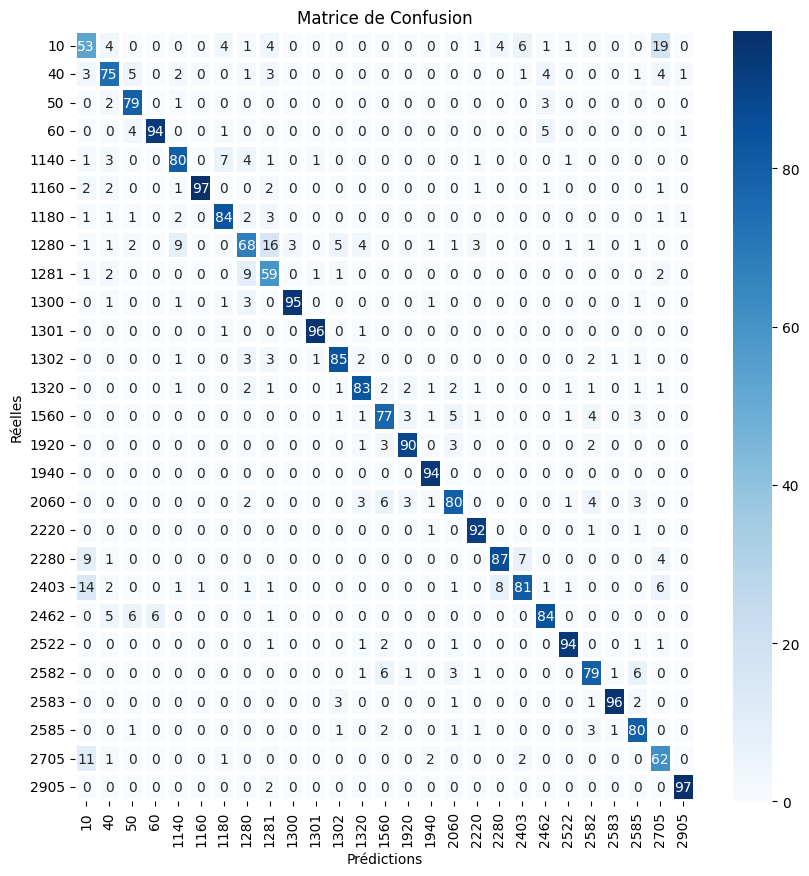

In [38]:
import numpy as np

y_pred = np.concatenate((y_pred_desc, y_pred_desi))
y_true = np.concatenate((y_desc, y_desi))

RktnModel_desi.evaluateTestResults(y_true,y_pred, label_encoder)
